###### Table of contents
1. [Automating screening of papers](#Automating-screening-of-papers)
2. [Workflow using BERT embeddings implementations](#I.-Title-and-abstract-only-classification-using-BERT-implementations:)
3. [BERT based text classification](#BERT-Embeddings-for-text-classification)
4. [Titles only](#Titles-only)
5. [Titles and abstract](#Titles-and-abstracts)
6. [BioBERT based text classification](#BioBERT-Embeddings-for-text-classification)
7. [Titles only](#Titles-only-BioBERT)
5. [Titles and abstract](#Titles-and-abstracts-BioBERT)
8. [Summary](#Summary)
9. [BioBERT-dmis-lab](#BioBERT-dmis-lab/biobert-base-cased-v1.1)
10. [Titles only](#Text-classification,-titles-only-using-BioBERT-dmis-lab)
11. [Titles and abstract](#Text-classification-Title-and-abstract-using-BioBERT-dmis-lab)

# Automating screening of papers

Try and test different approaches and evaluate which one of these is better.

**I) Use text classification using embeddings**

    a) Titles only
    b) Titles and abstracts only
    
Use Linear or non-linear methods for dimension reduction.

**II) Prompt engineering using Llama 🦙 (open source), ChatGPT (paid version) etc**

    a) Eligibility criteria (inclusion and exclusion criteria).
    b) Extract PICO and other necessary terms from the text (relevant features) and these can be used alongside the score to determine whether to include or not.

# I. Title and abstract only classification using BERT implementations:

* **BERT regular**
* **BioBERT**

The workflow below details my strategy of classifying articles by title and title and abstract only using BERT implementations.

![Autoscreeningstrategy](../Images/Screening_usingBERT.png)


# Install and load libraries

In [38]:
#Install libraries

# !pip install scikit-learn
# !pip install transformers
# !pip install torch torchvision
# !pip install matplotlib
# !pip install pandas
# !pip install numpy
# !pip install altair
# !pip install ipywidgets
# !conda install pytorch torchvision -c pytorch - has worked

In [39]:
# Import libraries
import pandas as pd
import numpy as np
import altair as alt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
# TOKENIZERS_PARALLELISM =True | False

# BERT Embeddings for text classification

## Titles only 

### Calculate embeddings and calculate the centroids.

In [40]:
# Using BERT a pre-trained model to generate embeddings
# Load a pre-trained model tokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')
# Func
def  get_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt',padding=True,truncation=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

def calculate_centroid(embeddings):
    return np.mean(embeddings,axis=0)



In [41]:
# Input
# Pre-classified sentences
accept_titles = ['The role of adiposity in cardiometabolic traits: a Mendelian randomization analysis','Age- and sex-specific causal effects of adiposity on cardiovascular risk factors','Causal Effect of Adiposity Measures on Blood Pressure Traits in 2 Urban Swedish Cohorts: A Mendelian Randomization Study'
]
reject_titles = ['The causal effects of health conditions and risk factors on social and socioeconomic outcomes: Mendelian randomization in UK Biobank','Association of serum HDL-cholesterol and apolipoprotein A1 levels with risk of severe SARS-CoV-2 infection','Effect of Systolic Blood Pressure on Left Ventricular Structure and Function: A Mendelian Randomization Study']
# Getting embeddings
accept_embeddings = [get_embedding(sent)for sent in accept_titles]

reject_embeddings = [get_embedding(sent)for sent in reject_titles]
# Calculate the average locations (centroids)
accept_centroid = calculate_centroid(accept_embeddings)
reject_centroid = calculate_centroid(reject_embeddings)


## Predict new title using BERT

In [42]:
# Classify a new title

new_title = 'Association between alcohol and cardiovascular disease: Mendelian randomisation analysis based on individual participant data.'
new_embedding = get_embedding(new_title)

# Measure distance to the centroids

distance_to_accept = np.linalg.norm(new_embedding - accept_centroid)
distance_to_reject = np.linalg.norm(new_embedding - reject_centroid)
print(distance_to_accept)
print(distance_to_reject)
# Classification
if distance_to_accept < distance_to_reject:
    classification = 'Accept'
else:
    classification = 'Reject'

print(classification)

4.030571
4.5406895
Accept


BERT with title only, new title misclassified. The new article is on alcohol and CVD as opposed to obesity and hypertension, blood opressure etc.

## Use a dimensionality reduction to visualise the embeddings

Use t-SNE to reduce the embeddings from 768D to 2D


(6, 768)


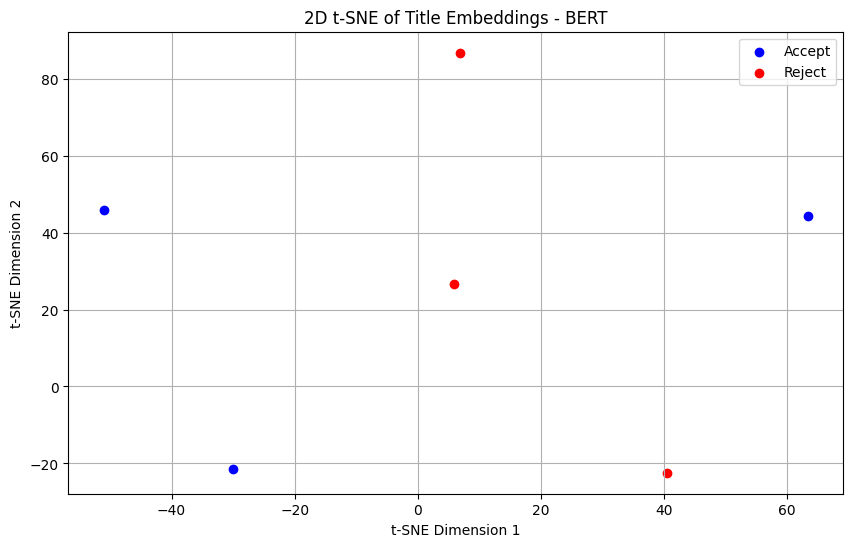

In [43]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

# Concatenate all embeddings
all_embeddings = np.concatenate((accept_embeddings,reject_embeddings),axis=0)

all_embeddings = np.squeeze(all_embeddings,axis=1)

print(all_embeddings.shape)

# Reduce the dimensionality
# Set the perplexity to a value less than the number of samples
perplexity_value = min(30, len(all_embeddings)-1)

#Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2,random_state=42,perplexity=perplexity_value)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Visualise the embeddings
num_accept = len(accept_embeddings)
# Plotting
plt.figure(figsize=(10,6))
plt.scatter(embeddings_2d[:num_accept,0],embeddings_2d[:num_accept,1],color='b',label='Accept')
plt.scatter(embeddings_2d[num_accept:,0],embeddings_2d[num_accept:,1],color='r',label='Reject')

plt.title("2D t-SNE of Title Embeddings - BERT")

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

## Titles and abstracts BERT

### Calculate embeddings and calculate the centroid

In [44]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Load a BERT model tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

# Write two functions (get_embeddings and calculate_centroid)
def get_embeddings(text):
    '''
    This function takes in a piece of text, tokenized using the autotokenizer.
    The tokezer output is fed to the model to generate the embeddings of that given text.
    '''
    inputs = tokenizer(text, truncation= True, return_tensors='pt',padding=True)
    outputs= model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Calculate the centroid - we calculate this by getting the mean of embeddings using numpy
def centroid_calculator(embeddings):
    '''
    This function takes in embeddings and returns the mean of the embeddings which is also average location
    '''
    return np.mean(embeddings, axis=0)

# Input - UPDATED WITH ABSTRACTS, titles separated from the abstract by a full stop
# Annotated dataset from Reviewer 1 (WNG), Accepted for included and rejected for excluded
Accepted = ['''The role of adiposity in cardiometabolic traits: a Mendelian randomization analysis. Background: The association between adiposity and cardiometabolic traits is well known from epidemiological studies. Whilst the causal relationship is clear for some of these traits, for others it is not. We aimed to determine whether adiposity is causally related to various cardiometabolic traits using the Mendelian randomization approach.

Methods and findings: We used the adiposity-associated variant rs9939609 at the FTO locus as an instrumental variable (IV) for body mass index (BMI) in a Mendelian randomization design. Thirty-six population-based studies of individuals of European descent contributed to the analyses. Age- and sex-adjusted regression models were fitted to test for association between (i) rs9939609 and BMI (n = 198,502), (ii) rs9939609 and 24 traits, and (iii) BMI and 24 traits. The causal effect of BMI on the outcome measures was quantified by IV estimators. The estimators were compared to the BMI-trait associations derived from the same individuals. In the IV analysis, we demonstrated novel evidence for a causal relationship between adiposity and incident heart failure (hazard ratio, 1.19 per BMI-unit increase; 95% CI, 1.03-1.39) and replicated earlier reports of a causal association with type 2 diabetes, metabolic syndrome, dyslipidemia, and hypertension (odds ratio for IV estimator, 1.1-1.4; all p < 0.05). For quantitative traits, our results provide novel evidence for a causal effect of adiposity on the liver enzymes alanine aminotransferase and gamma-glutamyl transferase and confirm previous reports of a causal effect of adiposity on systolic and diastolic blood pressure, fasting insulin, 2-h post-load glucose from the oral glucose tolerance test, C-reactive protein, triglycerides, and high-density lipoprotein cholesterol levels (all p < 0.05). The estimated causal effects were in agreement with traditional observational measures in all instances except for type 2 diabetes, where the causal estimate was larger than the observational estimate (p = 0.001).

Conclusions: We provide novel evidence for a causal relationship between adiposity and heart failure as well as between adiposity and increased liver enzymes.''',

            '''Age- and sex-specific causal effects of adiposity on cardiovascular risk factors.Observational studies have reported different effects of adiposity on cardiovascular risk factors across age and sex. Since cardiovascular risk factors are enriched in obese individuals, it has not been easy to dissect the effects of adiposity from those of other risk factors. We used a Mendelian randomization approach, applying a set of 32 genetic markers to estimate the causal effect of adiposity on blood pressure, glycemic indices, circulating lipid levels, and markers of inflammation and liver disease in up to 67,553 individuals. All analyses were stratified by age (cutoff 55 years of age) and sex. The genetic score was associated with BMI in both nonstratified analysis (P = 2.8 × 10−107) and stratified analyses (all P < 3.3 × 10−30). We found evidence of a causal effect of adiposity on blood pressure, fasting levels of insulin, C-reactive protein, interleukin-6, HDL cholesterol, and triglycerides in a nonstratified analysis and in the <55-year stratum. Further, we found evidence of a smaller causal effect on total cholesterol (P for difference = 0.015) in the ≥55-year stratum than in the <55-year stratum, a finding that could be explained by biology, survival bias, or differential medication. In conclusion, this study extends previous knowledge of the effects of adiposity by providing sex- and age-specific causal estimates on cardiovascular risk factors.''',
            '''Causal Effect of Adiposity Measures on Blood Pressure Traits in 2 Urban Swedish Cohorts: A Mendelian Randomization Study.Background Different adiposity traits may be causally related to hypertension in different ways. By using genetic variants as randomly allocated proxies for studying the effect of modifying adiposity traits, the Mendelian randomization approach can be used to investigate this. Methods and Results In this study, we used 4 different genetic risk scores (GRS; GRS-BMI565, GRS-WHR324, GRS-VAT208, GRS-BF81) including hundreds of single nucleotide polymorphisms associated with body mass index, waist-to-hip ratio, visceral adipose tissue, and body fat, respectively. These were applied as instrumental variables in Mendelian randomization analyses. Two Swedish urban-based cohort studies, the Malmö Diet and Cancer, and the Malmö Preventive 795Projects were used to obtain genetic association estimates with blood pressure (BP). In both the Malmö Preventive Projects and Malmö Diet and Cancer studies, except for that for body fat, all of the genetic risk scores were significantly associated with systolic BP and diastolic BP, but with different magnitudes. In particular, in both cohorts, each standard deviation increase in the genetic risk score made up by the 324 single nucleotide polymorphisms associated with waist-to-hip ratio was associated with doubling of the likelihood of hypertension prevalence at baseline. However, only the genetic risk score made up by the 565 SNPs associated with body mass index was significantly associated with hypertension incidence during 23.6±4.3 years of follow-up in the Malmö Preventive Project. Conclusions We support a causal link between genetically mediated adiposity, especially waist-to-hip ratio and body mass index, and BP traits including hypertension prevalence and, for the first time to our knowledge, hypertension incidence. The differences in magnitude between these associations might suggest different mechanisms by which different adiposity affects BP/hypertension and consequently may indicate that tailored interventions are needed to reduce cardiovascular risk. ''']

Rejected  = ['''The causal effects of health conditions and risk factors on social and socioeconomic outcomes: Mendelian randomization in UK Biobank.Background
We aimed to estimate the causal effect of health conditions and risk factors on social and socioeconomic outcomes in UK Biobank. Evidence on socioeconomic impacts is important to understand because it can help governments, policy makers and decision makers allocate resources efficiently and effectively.
Methods
We used Mendelian randomization to estimate the causal effects of eight health conditions (asthma, breast cancer, coronary heart disease, depression, eczema, migraine, osteoarthritis, type 2 diabetes) and five health risk factors [alcohol intake, body mass index (BMI), cholesterol, systolic blood pressure, smoking] on 19 social and socioeconomic outcomes in 336 997 men and women of White British ancestry in UK Biobank, aged between 39 and 72 years. Outcomes included annual household income, employment, deprivation [measured by the Townsend deprivation index (TDI)], degree-level education, happiness, loneliness and 13 other social and socioeconomic outcomes.
Results
Results suggested that BMI, smoking and alcohol intake affect many socioeconomic outcomes. For example, smoking was estimated to reduce household income [mean difference = -£22 838, 95% confidence interval (CI): -£31 354 to -£14 321] and the chance of owning accommodation [absolute percentage change (APC) = -20.8%, 95% CI: -28.2% to -13.4%], of being satisfied with health (APC = -35.4%, 95% CI: -51.2% to -19.5%) and of obtaining a university degree (APC = -65.9%, 95% CI: -81.4% to -50.4%), while also increasing deprivation (mean difference in TDI = 1.73, 95% CI: 1.02 to 2.44, approximately 216% of a decile of TDI). There was evidence that asthma decreased household income, the chance of obtaining a university degree and the chance of cohabiting, and migraine reduced the chance of having a weekly leisure or social activity, especially in men. For other associations, estimates were null.
Conclusions
Higher BMI, alcohol intake and smoking were all estimated to adversely affect multiple social and socioeconomic outcomes. Effects were not detected between health conditions and socioeconomic outcomes using Mendelian randomization, with the exceptions of depression, asthma and migraines. This may reflect true null associations, selection bias given the relative health and age of participants in UK Biobank, and/or lack of power to detect effects.''',
             '''Association of serum HDL-cholesterol and apolipoprotein A1 levels with risk of severe SARS-CoV-2 infection. Individuals with features of metabolic syndrome are particularly susceptible to severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2), a novel coronavirus associated with the severe respiratory disease, coronavirus disease 2019 (COVID-19). Despite considerable attention dedicated to COVID-19, the link between metabolic syndrome and SARS-CoV-2 infection remains unclear. Using data from the UK Biobank, we investigated the relationship between severity of COVID-19 and metabolic syndrome-related serum biomarkers measured prior to SARS-CoV-2 infection. Logistic regression analyses were used to test biomarker levels and biomarker-associated genetic variants with SARS-CoV-2-related outcomes. Among SARS-CoV-2-positive cases and negative controls, a 10 mg/dl increase in serum HDL-cholesterol or apolipoprotein A1 levels was associated with ∼10% reduced risk of SARS-CoV-2 infection, after adjustment for age, sex, obesity, hypertension, type 2 diabetes, and coronary artery disease. Evaluation of known genetic variants for HDL-cholesterol revealed that individuals homozygous for apolipoprotein E4 alleles had ∼2- to 3-fold higher risk of SARS-CoV-2 infection or mortality from COVID-19 compared with apolipoprotein E3 homozygotes, even after adjustment for HDL-cholesterol levels. However, cumulative effects of all evaluated HDL-cholesterol-raising alleles and Mendelian randomization analyses did not reveal association of genetically higher HDL-cholesterol levels with decreased risk of SARS-CoV-2 infection. These results implicate serum HDL-cholesterol and apolipoprotein A1 levels measured prior to SAR-CoV-2 exposure as clinical risk factors for severe COVID-19 infection but do not provide evidence that genetically elevated HDL-cholesterol levels are associated with SAR-CoV-2 infection.''',
             '''Effect of Systolic Blood Pressure on Left Ventricular Structure and Function: A Mendelian Randomization Study.We aimed to estimate the effects of a lifelong exposure to high systolic blood pressure (SBP) on left ventricular (LV) structure and function using Mendelian randomization. A total of 5596 participants of the UK Biobank were included for whom cardiovascular magnetic resonance imaging and genetic data were available. Major exclusion criteria included nonwhite ethnicity, major cardiovascular disease, and body mass index >30 or <18.5 kg/m2. A genetic risk score to estimate genetically predicted SBP (gSBP) was constructed based on 107 previously established genetic variants. Manual cardiovascular magnetic resonance imaging postprocessing analyses were performed in 300 individuals at the extremes of gSBP (150 highest and lowest). Multivariable linear regression analyses of imaging biomarkers were performed using gSBP as continuous independent variable. All analyses except myocardial strain were validated using previously derived imaging parameters in 2530 subjects. The mean (SD) age of the study population was 62 (7) years, and 52% of subjects were female. Corrected for age, sex, and body surface area, each 10 mm Hg increase in gSBP was significantly (P<0.0056) associated with 4.01 g (SE, 1.28; P=0.002) increase in LV mass and with 2.80% (SE, 0.97; P=0.004) increase in LV global radial strain. In the validation cohort, after correction for age, sex, and body surface area, each 10 mm Hg increase in gSBP was associated with 5.27 g (SE, 1.50; P<0.001) increase in LV mass. Our study provides a novel line of evidence for a causal relationship between SBP and increased LV mass and with increased LV global radial strain.''']

# Get the embeddings for accepted and rejected
# Using the concept of list comrehension, loop through the titles and abstracts and generate embeddings
accept_embeddings =[get_embeddings(text) for text in Accepted]
reject_embeddings =[get_embeddings(text) for text in Rejected]

# Centroid /average location calculator
accepted_centroid = centroid_calculator(accept_embeddings)
rejected_centroid = centroid_calculator(reject_embeddings)
    


## Predict new title with abstract using BERT

In [45]:
# Classify a new title and abstract

new_title_abs = '''Association between alcohol and cardiovascular disease: Mendelian randomisation analysis based on individual participant data.Objective: To use the rs1229984 variant in the alcohol dehydrogenase 1B gene (ADH1B) as an instrument to investigate the causal role of alcohol in cardiovascular disease.

Design: Mendelian randomisation meta-analysis of 56 epidemiological studies.

Participants: 261 991 individuals of European descent, including 20 259 coronary heart disease cases and 10 164 stroke events. Data were available on ADH1B rs1229984 variant, alcohol phenotypes, and cardiovascular biomarkers.

Main outcome measures: Odds ratio for coronary heart disease and stroke associated with the ADH1B variant in all individuals and by categories of alcohol consumption.

Results: Carriers of the A-allele of ADH1B rs1229984 consumed 17.2% fewer units of alcohol per week (95% confidence interval 15.6% to 18.9%), had a lower prevalence of binge drinking (odds ratio 0.78 (95% CI 0.73 to 0.84)), and had higher abstention (odds ratio 1.27 (1.21 to 1.34)) than non-carriers. Rs1229984 A-allele carriers had lower systolic blood pressure (-0.88 (-1.19 to -0.56) mm Hg), interleukin-6 levels (-5.2% (-7.8 to -2.4%)), waist circumference (-0.3 (-0.6 to -0.1) cm), and body mass index (-0.17 (-0.24 to -0.10) kg/m(2)). Rs1229984 A-allele carriers had lower odds of coronary heart disease (odds ratio 0.90 (0.84 to 0.96)). The protective association of the ADH1B rs1229984 A-allele variant remained the same across all categories of alcohol consumption (P=0.83 for heterogeneity). Although no association of rs1229984 was identified with the combined subtypes of stroke, carriers of the A-allele had lower odds of ischaemic stroke (odds ratio 0.83 (0.72 to 0.95)).

Conclusions: Individuals with a genetic variant associated with non-drinking and lower alcohol consumption had a more favourable cardiovascular profile and a reduced risk of coronary heart disease than those without the genetic variant. This suggests that reduction of alcohol consumption, even for light to moderate drinkers, is beneficial for cardiovascular health.'''
new_title_abs_embeddings = get_embeddings(new_title_abs)

# Measure distance from the centroids
distance_to_accept = np.linalg.norm(new_title_abs_embeddings - accepted_centroid)
distance_to_reject = np.linalg.norm(new_title_abs_embeddings - rejected_centroid)

print(distance_to_accept)
print(distance_to_reject)

# Classify based on how close they are to 
if distance_to_accept < distance_to_reject:
    classification = 'Accept'
else:
    classification = 'Reject'

print(classification)

2.6735861
2.34251
Reject


BERT with title and abstract despite truncating tokens to 512, it classifies the new article in the correct category.

(6, 768)


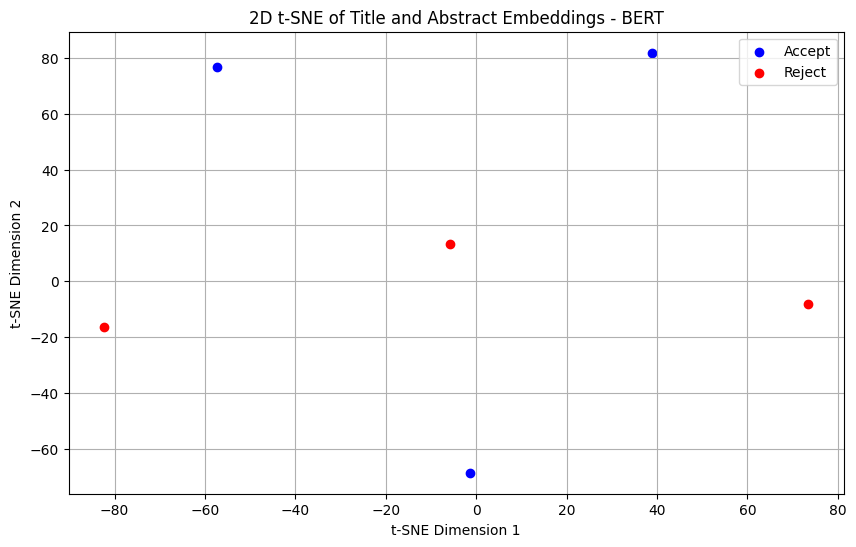

In [46]:
# Visualise

import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

# Concatenate all embeddings
all_embeddings = np.concatenate((accept_embeddings,reject_embeddings),axis=0)

all_embeddings = np.squeeze(all_embeddings,axis=1)

print(all_embeddings.shape)

# Reduce the dimensionality
# Set the perplexity to a value less than the number of samples
perplexity_value = min(30, len(all_embeddings)-1)

#Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2,random_state=42,perplexity=perplexity_value)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Visualise the embeddings
num_accepted = len(accept_embeddings)
# Plotting
plt.figure(figsize=(10,6))
plt.scatter(embeddings_2d[:num_accepted,0],embeddings_2d[:num_accepted,1],color='b',label='Accept')
plt.scatter(embeddings_2d[num_accepted:,0],embeddings_2d[num_accepted:,1],color='r',label='Reject')

plt.title("2D t-SNE of Title and Abstract Embeddings - BERT")

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

# BioBERT Embeddings for text classification

## Titles only BioBERT


### Calculate embeddings and calculate the centroids.


In [47]:
# Calculate the embeddings
# Load libraries as before
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
# Load a pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained('monologg/biobert_v1.1_pubmed')
model = AutoModel.from_pretrained('monologg/biobert_v1.1_pubmed')
# Func
def  get_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt',padding=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

def calculate_centroid(embeddings):
    return np.mean(embeddings,axis=0)


#Get embeddings
# input
#Pre-classified sentences
accept_titles = ['The role of adiposity in cardiometabolic traits: a Mendelian randomization analysis','Age- and sex-specific causal effects of adiposity on cardiovascular risk factors','Causal Effect of Adiposity Measures on Blood Pressure Traits in 2 Urban Swedish Cohorts: A Mendelian Randomization Study'
]
reject_titles = ['The causal effects of health conditions and risk factors on social and socioeconomic outcomes: Mendelian randomization in UK Biobank','Association of serum HDL-cholesterol and apolipoprotein A1 levels with risk of severe SARS-CoV-2 infection','Effect of Systolic Blood Pressure on Left Ventricular Structure and Function: A Mendelian Randomization Study']
# Getting embeddings
accept_embeddings = [get_embedding(sent)for sent in accept_titles]

reject_embeddings = [get_embedding(sent)for sent in reject_titles]

# Calculate the average locations (centroids)
accept_centroid = calculate_centroid(accept_embeddings)
reject_centroid = calculate_centroid(reject_embeddings)

## Predict new title using BioBERT

In [48]:
# Predict the category of a new title
new_title = 'Association between alcohol and cardiovascular disease: Mendelian randomisation analysis based on individual participant data.'
new_embedding = get_embedding(new_title)

# Measure distance to the centroids

distance_to_accept = np.linalg.norm(new_embedding - accept_centroid)
distance_to_reject = np.linalg.norm(new_embedding - reject_centroid)
print(distance_to_accept)
print(distance_to_reject)
# Classification
if distance_to_accept < distance_to_reject:
    classification = 'Accept'
else:
    classification = 'Reject'

print(classification)

3.4004838
3.4435525
Accept


When using BioBERT with Titles only it misclassifies the new title.

(6, 768)


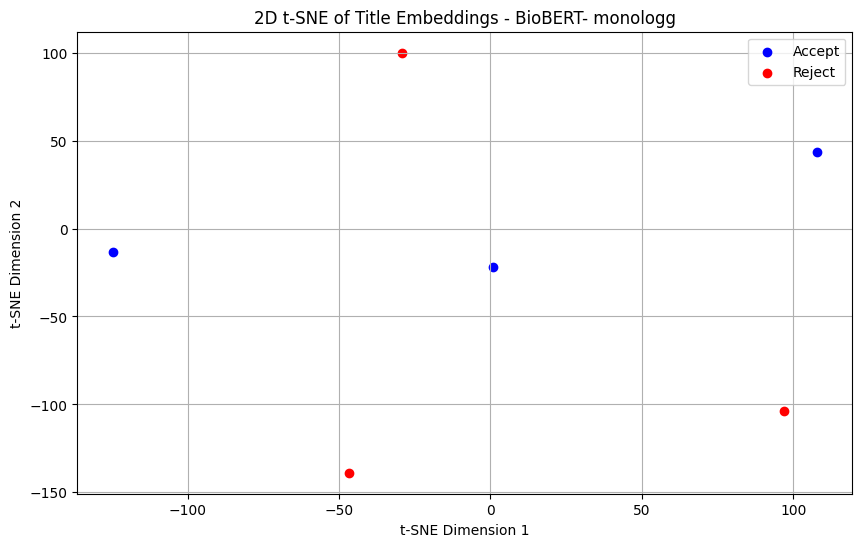

In [49]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

# Concatenate all embeddings
all_embeddings = np.concatenate((accept_embeddings,reject_embeddings),axis=0)

all_embeddings = np.squeeze(all_embeddings,axis=1)

print(all_embeddings.shape)

# Reduce the dimensionality
# Set the perplexity to a value less than the number of samples
perplexity_value = min(30, len(all_embeddings)-1)

#Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2,random_state=42,perplexity=perplexity_value)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Visualise the embeddings
num_accept = len(accept_embeddings)
# Plotting
plt.figure(figsize=(10,6))
plt.scatter(embeddings_2d[:num_accept,0],embeddings_2d[:num_accept,1],color='b',label='Accept')
plt.scatter(embeddings_2d[num_accept:,0],embeddings_2d[num_accept:,1],color='r',label='Reject')

plt.title("2D t-SNE of Title Embeddings - BioBERT- monologg")

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

## Titles and abstracts BioBERT

### Calculate embeddings and calculate the centroids.

In [50]:
# Load a BERT model tokenizer
tokenizer = AutoTokenizer.from_pretrained('monologg/biobert_v1.1_pubmed')
model = AutoModel.from_pretrained('monologg/biobert_v1.1_pubmed')

# Write two functions (get_embeddings and calculate_centroid)
def get_embeddings(text):
    '''
    This function takes in a piece of text, tokenized using the autotokenizer.
    The tokezer output is fed to the model to generate the embeddings of that given text.
    '''
    inputs = tokenizer(text, return_tensors='pt',truncation=True, max_length = 512,padding=True)
    outputs= model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Calculate the centroid - we calculate this by getting the mean of embeddings using numpy
def centroid_calculator(embeddings):
    '''
    This function takes in embeddings and returns the mean of the embeddings which is also average location
    '''
    return np.mean(embeddings, axis=0)

# Input - UPDATED WITH ABSTRACTS, titles separated from the abstract by a full stop
# Annotated dataset from Reviewer 1 (WNG), Accepted for included and rejected for excluded
Accepted = ['''The role of adiposity in cardiometabolic traits: a Mendelian randomization analysis. Background: The association between adiposity and cardiometabolic traits is well known from epidemiological studies. Whilst the causal relationship is clear for some of these traits, for others it is not. We aimed to determine whether adiposity is causally related to various cardiometabolic traits using the Mendelian randomization approach.

Methods and findings: We used the adiposity-associated variant rs9939609 at the FTO locus as an instrumental variable (IV) for body mass index (BMI) in a Mendelian randomization design. Thirty-six population-based studies of individuals of European descent contributed to the analyses. Age- and sex-adjusted regression models were fitted to test for association between (i) rs9939609 and BMI (n = 198,502), (ii) rs9939609 and 24 traits, and (iii) BMI and 24 traits. The causal effect of BMI on the outcome measures was quantified by IV estimators. The estimators were compared to the BMI-trait associations derived from the same individuals. In the IV analysis, we demonstrated novel evidence for a causal relationship between adiposity and incident heart failure (hazard ratio, 1.19 per BMI-unit increase; 95% CI, 1.03-1.39) and replicated earlier reports of a causal association with type 2 diabetes, metabolic syndrome, dyslipidemia, and hypertension (odds ratio for IV estimator, 1.1-1.4; all p < 0.05). For quantitative traits, our results provide novel evidence for a causal effect of adiposity on the liver enzymes alanine aminotransferase and gamma-glutamyl transferase and confirm previous reports of a causal effect of adiposity on systolic and diastolic blood pressure, fasting insulin, 2-h post-load glucose from the oral glucose tolerance test, C-reactive protein, triglycerides, and high-density lipoprotein cholesterol levels (all p < 0.05). The estimated causal effects were in agreement with traditional observational measures in all instances except for type 2 diabetes, where the causal estimate was larger than the observational estimate (p = 0.001).

Conclusions: We provide novel evidence for a causal relationship between adiposity and heart failure as well as between adiposity and increased liver enzymes.''',

            '''Age- and sex-specific causal effects of adiposity on cardiovascular risk factors.Observational studies have reported different effects of adiposity on cardiovascular risk factors across age and sex. Since cardiovascular risk factors are enriched in obese individuals, it has not been easy to dissect the effects of adiposity from those of other risk factors. We used a Mendelian randomization approach, applying a set of 32 genetic markers to estimate the causal effect of adiposity on blood pressure, glycemic indices, circulating lipid levels, and markers of inflammation and liver disease in up to 67,553 individuals. All analyses were stratified by age (cutoff 55 years of age) and sex. The genetic score was associated with BMI in both nonstratified analysis (P = 2.8 × 10−107) and stratified analyses (all P < 3.3 × 10−30). We found evidence of a causal effect of adiposity on blood pressure, fasting levels of insulin, C-reactive protein, interleukin-6, HDL cholesterol, and triglycerides in a nonstratified analysis and in the <55-year stratum. Further, we found evidence of a smaller causal effect on total cholesterol (P for difference = 0.015) in the ≥55-year stratum than in the <55-year stratum, a finding that could be explained by biology, survival bias, or differential medication. In conclusion, this study extends previous knowledge of the effects of adiposity by providing sex- and age-specific causal estimates on cardiovascular risk factors.''',
            '''Causal Effect of Adiposity Measures on Blood Pressure Traits in 2 Urban Swedish Cohorts: A Mendelian Randomization Study.Background Different adiposity traits may be causally related to hypertension in different ways. By using genetic variants as randomly allocated proxies for studying the effect of modifying adiposity traits, the Mendelian randomization approach can be used to investigate this. Methods and Results In this study, we used 4 different genetic risk scores (GRS; GRS-BMI565, GRS-WHR324, GRS-VAT208, GRS-BF81) including hundreds of single nucleotide polymorphisms associated with body mass index, waist-to-hip ratio, visceral adipose tissue, and body fat, respectively. These were applied as instrumental variables in Mendelian randomization analyses. Two Swedish urban-based cohort studies, the Malmö Diet and Cancer, and the Malmö Preventive 795Projects were used to obtain genetic association estimates with blood pressure (BP). In both the Malmö Preventive Projects and Malmö Diet and Cancer studies, except for that for body fat, all of the genetic risk scores were significantly associated with systolic BP and diastolic BP, but with different magnitudes. In particular, in both cohorts, each standard deviation increase in the genetic risk score made up by the 324 single nucleotide polymorphisms associated with waist-to-hip ratio was associated with doubling of the likelihood of hypertension prevalence at baseline. However, only the genetic risk score made up by the 565 SNPs associated with body mass index was significantly associated with hypertension incidence during 23.6±4.3 years of follow-up in the Malmö Preventive Project. Conclusions We support a causal link between genetically mediated adiposity, especially waist-to-hip ratio and body mass index, and BP traits including hypertension prevalence and, for the first time to our knowledge, hypertension incidence. The differences in magnitude between these associations might suggest different mechanisms by which different adiposity affects BP/hypertension and consequently may indicate that tailored interventions are needed to reduce cardiovascular risk. ''']

Rejected  = ['''The causal effects of health conditions and risk factors on social and socioeconomic outcomes: Mendelian randomization in UK Biobank.Background
We aimed to estimate the causal effect of health conditions and risk factors on social and socioeconomic outcomes in UK Biobank. Evidence on socioeconomic impacts is important to understand because it can help governments, policy makers and decision makers allocate resources efficiently and effectively.
Methods: We used Mendelian randomization to estimate the causal effects of eight health conditions (asthma, breast cancer, coronary heart disease, depression, eczema, migraine, osteoarthritis, type 2 diabetes) and five health risk factors [alcohol intake, body mass index (BMI), cholesterol, systolic blood pressure, smoking] on 19 social and socioeconomic outcomes in 336 997 men and women of White British ancestry in UK Biobank, aged between 39 and 72 years. Outcomes included annual household income, employment, deprivation [measured by the Townsend deprivation index (TDI)], degree-level education, happiness, loneliness and 13 other social and socioeconomic outcomes.
Results: Results suggested that BMI, smoking and alcohol intake affect many socioeconomic outcomes. For example, smoking was estimated to reduce household income [mean difference = -£22 838, 95% confidence interval (CI): -£31 354 to -£14 321] and the chance of owning accommodation [absolute percentage change (APC) = -20.8%, 95% CI: -28.2% to -13.4%], of being satisfied with health (APC = -35.4%, 95% CI: -51.2% to -19.5%) and of obtaining a university degree (APC = -65.9%, 95% CI: -81.4% to -50.4%), while also increasing deprivation (mean difference in TDI = 1.73, 95% CI: 1.02 to 2.44, approximately 216% of a decile of TDI). There was evidence that asthma decreased household income, the chance of obtaining a university degree and the chance of cohabiting, and migraine reduced the chance of having a weekly leisure or social activity, especially in men. For other associations, estimates were null.
Conclusions :Higher BMI, alcohol intake and smoking were all estimated to adversely affect multiple social and socioeconomic outcomes. Effects were not detected between health conditions and socioeconomic outcomes using Mendelian randomization, with the exceptions of depression, asthma and migraines. This may reflect true null associations, selection bias given the relative health and age of participants in UK Biobank, and/or lack of power to detect effects.''',
             '''Association of serum HDL-cholesterol and apolipoprotein A1 levels with risk of severe SARS-CoV-2 infection. Individuals with features of metabolic syndrome are particularly susceptible to severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2), a novel coronavirus associated with the severe respiratory disease, coronavirus disease 2019 (COVID-19). Despite considerable attention dedicated to COVID-19, the link between metabolic syndrome and SARS-CoV-2 infection remains unclear. Using data from the UK Biobank, we investigated the relationship between severity of COVID-19 and metabolic syndrome-related serum biomarkers measured prior to SARS-CoV-2 infection. Logistic regression analyses were used to test biomarker levels and biomarker-associated genetic variants with SARS-CoV-2-related outcomes. Among SARS-CoV-2-positive cases and negative controls, a 10 mg/dl increase in serum HDL-cholesterol or apolipoprotein A1 levels was associated with ∼10% reduced risk of SARS-CoV-2 infection, after adjustment for age, sex, obesity, hypertension, type 2 diabetes, and coronary artery disease. Evaluation of known genetic variants for HDL-cholesterol revealed that individuals homozygous for apolipoprotein E4 alleles had ∼2- to 3-fold higher risk of SARS-CoV-2 infection or mortality from COVID-19 compared with apolipoprotein E3 homozygotes, even after adjustment for HDL-cholesterol levels. However, cumulative effects of all evaluated HDL-cholesterol-raising alleles and Mendelian randomization analyses did not reveal association of genetically higher HDL-cholesterol levels with decreased risk of SARS-CoV-2 infection. These results implicate serum HDL-cholesterol and apolipoprotein A1 levels measured prior to SAR-CoV-2 exposure as clinical risk factors for severe COVID-19 infection but do not provide evidence that genetically elevated HDL-cholesterol levels are associated with SAR-CoV-2 infection.''',
             '''Effect of Systolic Blood Pressure on Left Ventricular Structure and Function: A Mendelian Randomization Study.We aimed to estimate the effects of a lifelong exposure to high systolic blood pressure (SBP) on left ventricular (LV) structure and function using Mendelian randomization. A total of 5596 participants of the UK Biobank were included for whom cardiovascular magnetic resonance imaging and genetic data were available. Major exclusion criteria included nonwhite ethnicity, major cardiovascular disease, and body mass index >30 or <18.5 kg/m2. A genetic risk score to estimate genetically predicted SBP (gSBP) was constructed based on 107 previously established genetic variants. Manual cardiovascular magnetic resonance imaging postprocessing analyses were performed in 300 individuals at the extremes of gSBP (150 highest and lowest). Multivariable linear regression analyses of imaging biomarkers were performed using gSBP as continuous independent variable. All analyses except myocardial strain were validated using previously derived imaging parameters in 2530 subjects. The mean (SD) age of the study population was 62 (7) years, and 52% of subjects were female. Corrected for age, sex, and body surface area, each 10 mm Hg increase in gSBP was significantly (P<0.0056) associated with 4.01 g (SE, 1.28; P=0.002) increase in LV mass and with 2.80% (SE, 0.97; P=0.004) increase in LV global radial strain. In the validation cohort, after correction for age, sex, and body surface area, each 10 mm Hg increase in gSBP was associated with 5.27 g (SE, 1.50; P<0.001) increase in LV mass. Our study provides a novel line of evidence for a causal relationship between SBP and increased LV mass and with increased LV global radial strain.''']



In [51]:
#Get the embeddings for accepted and rejected
#Using the concept of list comrehension, loop through the titles and abstracts and generate embeddings
accept_embeddings =[get_embeddings(text) for text in Accepted]
reject_embeddings =[get_embeddings(text) for text in Rejected]

# Centroid /average location calculator
accepted_centroid = centroid_calculator(accept_embeddings)
rejected_centroid = centroid_calculator(reject_embeddings)

## Predict new title with abstract using BioBERT

In [52]:
# Predict a category for new title and abstract
# Classify a new title and abstract

new_title_abs = '''Association between alcohol and cardiovascular disease: Mendelian randomisation analysis based on individual participant data.Objective: To use the rs1229984 variant in the alcohol dehydrogenase 1B gene (ADH1B) as an instrument to investigate the causal role of alcohol in cardiovascular disease.

Design: Mendelian randomisation meta-analysis of 56 epidemiological studies.

Participants: 261 991 individuals of European descent, including 20 259 coronary heart disease cases and 10 164 stroke events. Data were available on ADH1B rs1229984 variant, alcohol phenotypes, and cardiovascular biomarkers.

Main outcome measures: Odds ratio for coronary heart disease and stroke associated with the ADH1B variant in all individuals and by categories of alcohol consumption.

Results: Carriers of the A-allele of ADH1B rs1229984 consumed 17.2% fewer units of alcohol per week (95% confidence interval 15.6% to 18.9%), had a lower prevalence of binge drinking (odds ratio 0.78 (95% CI 0.73 to 0.84)), and had higher abstention (odds ratio 1.27 (1.21 to 1.34)) than non-carriers. Rs1229984 A-allele carriers had lower systolic blood pressure (-0.88 (-1.19 to -0.56) mm Hg), interleukin-6 levels (-5.2% (-7.8 to -2.4%)), waist circumference (-0.3 (-0.6 to -0.1) cm), and body mass index (-0.17 (-0.24 to -0.10) kg/m(2)). Rs1229984 A-allele carriers had lower odds of coronary heart disease (odds ratio 0.90 (0.84 to 0.96)). The protective association of the ADH1B rs1229984 A-allele variant remained the same across all categories of alcohol consumption (P=0.83 for heterogeneity). Although no association of rs1229984 was identified with the combined subtypes of stroke, carriers of the A-allele had lower odds of ischaemic stroke (odds ratio 0.83 (0.72 to 0.95)).

Conclusions: Individuals with a genetic variant associated with non-drinking and lower alcohol consumption had a more favourable cardiovascular profile and a reduced risk of coronary heart disease than those without the genetic variant. This suggests that reduction of alcohol consumption, even for light to moderate drinkers, is beneficial for cardiovascular health.'''
new_title_abs_embeddings = get_embeddings(new_title_abs)

# Measure distance from the centroids
distance_to_accept = np.linalg.norm(new_title_abs_embeddings - accepted_centroid)
distance_to_reject = np.linalg.norm(new_title_abs_embeddings - rejected_centroid)

print(distance_to_accept)
print(distance_to_reject)

# Classify based on how close they are to 
if distance_to_accept < distance_to_reject:
    classification = 'Accept'
else:
    classification = 'Reject'

print(classification)

2.2967129
1.9663982
Reject


BioBERT with title and abstract gave similar prediction as expert evaluation.

(6, 768)


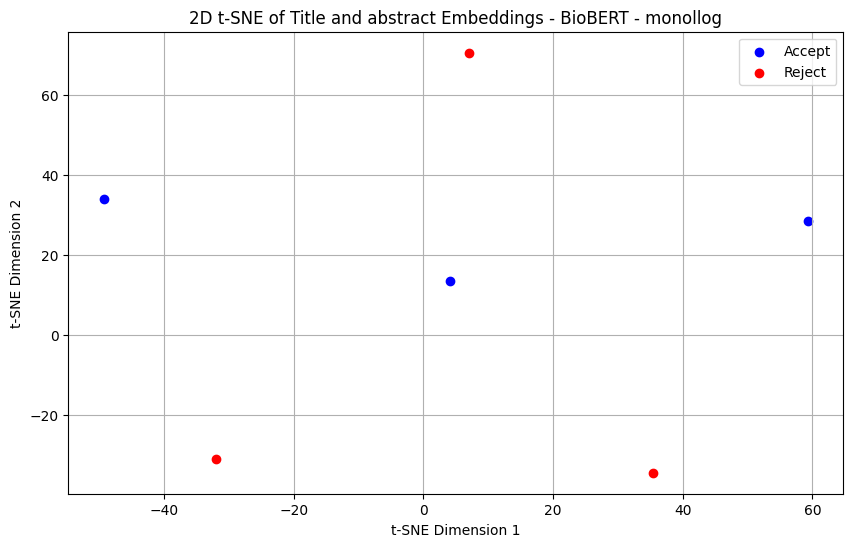

In [53]:
# Visualise

import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

# Concatenate all embeddings
all_embeddings = np.concatenate((accept_embeddings,reject_embeddings),axis=0)

all_embeddings = np.squeeze(all_embeddings,axis=1)

print(all_embeddings.shape)

# Reduce the dimensionality
# Set the perplexity to a value less than the number of samples
perplexity_value = min(30, len(all_embeddings)-1)

#Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2,random_state=42,perplexity=perplexity_value)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Visualise the embeddings
num_accepted = len(accept_embeddings)
# Plotting
plt.figure(figsize=(10,6))
plt.scatter(embeddings_2d[:num_accepted,0],embeddings_2d[:num_accepted,1],color='b',label='Accept')
plt.scatter(embeddings_2d[num_accepted:,0],embeddings_2d[num_accepted:,1],color='r',label='Reject')

plt.title("2D t-SNE of Title and abstract Embeddings - BioBERT - monollog")

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

# Summary

## Input
* Three included papers

* Three excluded papers

## New article - to be classified
Title and abstract - expert view the paper should be exlcuded (reject).

## Opportunities, challenges and solutions
Title only easy to process short text.

Title and abstract, the tokens exceed the allowed limit of 512; *Error message*.

Ideally I should clean the data before tokenizing it i.e removing stop words and stemming, however tokenization with BERT ensures generation of contextually meaningful embeddings. [Comparison of BERT implementation in medical Docs](https://www.sciencedirect.com/science/article/pii/S2352914822002763)

How did I approach the problem of >512 tokens?

I have used the truncation argument within the function and set the limit of maximum length to 512, when the number of tokens exceed 512, we truncate the rest of the tokens. The danger here is I will lose some relevant information. Nevertheless, currently the model seem to be doing all fine but in coming weeks I will explore other strategies including:

I) Chunk the title and abstract to bits of up to 512 tokens.

II) Preprocessing of the titles and abstracts before tokenizing (Not sure how useful this will be).


# Implementation

1. Classifying a new article by title only, by measuring how far or close it is to the embeddings centroids, the prediction is **wrong** using **BERT** and **BIOBERT**.

   [BERT title only](#Predict-new-title-using-BERT)

   [BioBERT title only](#Predict-new-title-using-BioBERT)

3. Classifying a new article by title and abstract, by measuring how far or close it is to the embeddings centroids, the prediction is **correct** using **BERT** and **BIOBERT**.

   [BERT title abstract](#Predict-new-title-with-abstract-using-BERT)

   [BioBERT title abstract](#Predict-new-title-with-abstract-using-BioBERT)



## Visualisation - Interpretation 

Title only and title with abstract visualisation from BERT (regular) and BioBERT-monologg/biobert_v1.1_pubmed the two categories are nearly indistinguishable.

BERT - Regular/base, this is expected since training is solely on English corpus and wikipedia text. 

BioBERT-monologg/biobert_v1.1_pubmed for some reason this does not give unique results despite containing pubmed abstracts during training. The next step is exploring other BioBERT implementations; `dmis-lab/biobert-base-cased-v1.1`.


# Next steps

1. Instead of truncating the text to 512 tokens, try and process the data in chunks of 512.

2. Use a different version of BioBERT `dmis-lab/biobert-base-cased-v1.1` - **Done**

3. My datasets is small, some examples I have seen implementing BERT model, have training set and hold-out validation set (Access to big datasets). Any thoughts?

4. Start exploring prompt engineering after Tom and Yi looks at the piece of work.

# BioBERT dmis-lab/biobert-base-cased-v1.1

# Text classification, titles only using BioBERT-dmis-lab

## Calculate embedding and centroids.

In [54]:
# Calculate the embeddings

# Load libraries as before
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
# Load a pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
model = AutoModel.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
# Func
def  get_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt',padding=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

def calculate_centroid(embeddings):
    return np.mean(embeddings,axis=0)


#Get embeddings
# input
#Pre-classified sentences
accept_titles = ['The role of adiposity in cardiometabolic traits: a Mendelian randomization analysis','Age- and sex-specific causal effects of adiposity on cardiovascular risk factors','Causal Effect of Adiposity Measures on Blood Pressure Traits in 2 Urban Swedish Cohorts: A Mendelian Randomization Study'
]
reject_titles = ['The causal effects of health conditions and risk factors on social and socioeconomic outcomes: Mendelian randomization in UK Biobank','Association of serum HDL-cholesterol and apolipoprotein A1 levels with risk of severe SARS-CoV-2 infection','Effect of Systolic Blood Pressure on Left Ventricular Structure and Function: A Mendelian Randomization Study']
# Getting embeddings
accept_embeddings = [get_embedding(sent)for sent in accept_titles]

reject_embeddings = [get_embedding(sent)for sent in reject_titles]

# Calculate the average locations (centroids)
accept_centroid = calculate_centroid(accept_embeddings)
reject_centroid = calculate_centroid(reject_embeddings)

## Predict category of new title using biobert dmis-lab

In [55]:
# Predict the category of a new title
new_title = 'Association between alcohol and cardiovascular disease: Mendelian randomisation analysis based on individual participant data.'
new_embedding = get_embedding(new_title)

# Measure distance to the centroids

distance_to_accept = np.linalg.norm(new_embedding - accept_centroid)
distance_to_reject = np.linalg.norm(new_embedding - reject_centroid)
print(distance_to_accept)
print(distance_to_reject)
# Classification
if distance_to_accept < distance_to_reject:
    classification = 'Accept'
else:
    classification = 'Reject'

print(classification)

3.1982694
3.2574534
Accept


The title's category is  wrong compared to expert knowledge.

# Visualise

(6, 768)


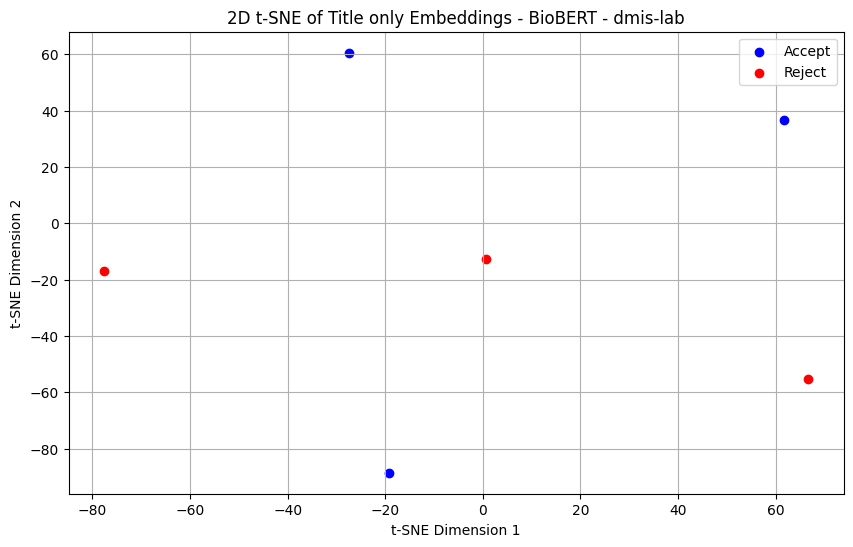

In [56]:
# Visualise

import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

# Concatenate all embeddings
all_embeddings = np.concatenate((accept_embeddings,reject_embeddings),axis=0)

all_embeddings = np.squeeze(all_embeddings,axis=1)

print(all_embeddings.shape)

# Reduce the dimensionality
# Set the perplexity to a value less than the number of samples
perplexity_value = min(30, len(all_embeddings)-1)

#Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2,random_state=42,perplexity=perplexity_value)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Visualise the embeddings
num_accepted = len(accept_embeddings)
# Plotting
plt.figure(figsize=(10,6))
plt.scatter(embeddings_2d[:num_accepted,0],embeddings_2d[:num_accepted,1],color='b',label='Accept')
plt.scatter(embeddings_2d[num_accepted:,0],embeddings_2d[num_accepted:,1],color='r',label='Reject')

plt.title("2D t-SNE of Title only Embeddings - BioBERT - dmis-lab")

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

# Text classification Title and abstract using BioBERT-dmis-lab

In [57]:
# Load a BERT model tokenizer
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
model = AutoModel.from_pretrained('dmis-lab/biobert-base-cased-v1.1')

# Write two functions (get_embeddings and calculate_centroid)
def get_embeddings(text):
    '''
    This function takes in a piece of text, tokenized using the autotokenizer.
    The tokezer output is fed to the model to generate the embeddings of that given text.
    '''
    inputs = tokenizer(text, return_tensors='pt',truncation=True, max_length = 512,padding=True)
    outputs= model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Calculate the centroid - we calculate this by getting the mean of embeddings using numpy
def centroid_calculator(embeddings):
    '''
    This function takes in embeddings and returns the mean of the embeddings which is also average location
    '''
    return np.mean(embeddings, axis=0)

# Input - UPDATED WITH ABSTRACTS, titles separated from the abstract by a full stop
# Annotated dataset from Reviewer 1 (WNG), Accepted for included and rejected for excluded
Accepted = ['''The role of adiposity in cardiometabolic traits: a Mendelian randomization analysis. Background: The association between adiposity and cardiometabolic traits is well known from epidemiological studies. Whilst the causal relationship is clear for some of these traits, for others it is not. We aimed to determine whether adiposity is causally related to various cardiometabolic traits using the Mendelian randomization approach.

Methods and findings: We used the adiposity-associated variant rs9939609 at the FTO locus as an instrumental variable (IV) for body mass index (BMI) in a Mendelian randomization design. Thirty-six population-based studies of individuals of European descent contributed to the analyses. Age- and sex-adjusted regression models were fitted to test for association between (i) rs9939609 and BMI (n = 198,502), (ii) rs9939609 and 24 traits, and (iii) BMI and 24 traits. The causal effect of BMI on the outcome measures was quantified by IV estimators. The estimators were compared to the BMI-trait associations derived from the same individuals. In the IV analysis, we demonstrated novel evidence for a causal relationship between adiposity and incident heart failure (hazard ratio, 1.19 per BMI-unit increase; 95% CI, 1.03-1.39) and replicated earlier reports of a causal association with type 2 diabetes, metabolic syndrome, dyslipidemia, and hypertension (odds ratio for IV estimator, 1.1-1.4; all p < 0.05). For quantitative traits, our results provide novel evidence for a causal effect of adiposity on the liver enzymes alanine aminotransferase and gamma-glutamyl transferase and confirm previous reports of a causal effect of adiposity on systolic and diastolic blood pressure, fasting insulin, 2-h post-load glucose from the oral glucose tolerance test, C-reactive protein, triglycerides, and high-density lipoprotein cholesterol levels (all p < 0.05). The estimated causal effects were in agreement with traditional observational measures in all instances except for type 2 diabetes, where the causal estimate was larger than the observational estimate (p = 0.001).

Conclusions: We provide novel evidence for a causal relationship between adiposity and heart failure as well as between adiposity and increased liver enzymes.''',

            '''Age- and sex-specific causal effects of adiposity on cardiovascular risk factors.Observational studies have reported different effects of adiposity on cardiovascular risk factors across age and sex. Since cardiovascular risk factors are enriched in obese individuals, it has not been easy to dissect the effects of adiposity from those of other risk factors. We used a Mendelian randomization approach, applying a set of 32 genetic markers to estimate the causal effect of adiposity on blood pressure, glycemic indices, circulating lipid levels, and markers of inflammation and liver disease in up to 67,553 individuals. All analyses were stratified by age (cutoff 55 years of age) and sex. The genetic score was associated with BMI in both nonstratified analysis (P = 2.8 × 10−107) and stratified analyses (all P < 3.3 × 10−30). We found evidence of a causal effect of adiposity on blood pressure, fasting levels of insulin, C-reactive protein, interleukin-6, HDL cholesterol, and triglycerides in a nonstratified analysis and in the <55-year stratum. Further, we found evidence of a smaller causal effect on total cholesterol (P for difference = 0.015) in the ≥55-year stratum than in the <55-year stratum, a finding that could be explained by biology, survival bias, or differential medication. In conclusion, this study extends previous knowledge of the effects of adiposity by providing sex- and age-specific causal estimates on cardiovascular risk factors.''',
            '''Causal Effect of Adiposity Measures on Blood Pressure Traits in 2 Urban Swedish Cohorts: A Mendelian Randomization Study.Background Different adiposity traits may be causally related to hypertension in different ways. By using genetic variants as randomly allocated proxies for studying the effect of modifying adiposity traits, the Mendelian randomization approach can be used to investigate this. Methods and Results In this study, we used 4 different genetic risk scores (GRS; GRS-BMI565, GRS-WHR324, GRS-VAT208, GRS-BF81) including hundreds of single nucleotide polymorphisms associated with body mass index, waist-to-hip ratio, visceral adipose tissue, and body fat, respectively. These were applied as instrumental variables in Mendelian randomization analyses. Two Swedish urban-based cohort studies, the Malmö Diet and Cancer, and the Malmö Preventive 795Projects were used to obtain genetic association estimates with blood pressure (BP). In both the Malmö Preventive Projects and Malmö Diet and Cancer studies, except for that for body fat, all of the genetic risk scores were significantly associated with systolic BP and diastolic BP, but with different magnitudes. In particular, in both cohorts, each standard deviation increase in the genetic risk score made up by the 324 single nucleotide polymorphisms associated with waist-to-hip ratio was associated with doubling of the likelihood of hypertension prevalence at baseline. However, only the genetic risk score made up by the 565 SNPs associated with body mass index was significantly associated with hypertension incidence during 23.6±4.3 years of follow-up in the Malmö Preventive Project. Conclusions We support a causal link between genetically mediated adiposity, especially waist-to-hip ratio and body mass index, and BP traits including hypertension prevalence and, for the first time to our knowledge, hypertension incidence. The differences in magnitude between these associations might suggest different mechanisms by which different adiposity affects BP/hypertension and consequently may indicate that tailored interventions are needed to reduce cardiovascular risk. ''']

Rejected  = ['''The causal effects of health conditions and risk factors on social and socioeconomic outcomes: Mendelian randomization in UK Biobank.Background
We aimed to estimate the causal effect of health conditions and risk factors on social and socioeconomic outcomes in UK Biobank. Evidence on socioeconomic impacts is important to understand because it can help governments, policy makers and decision makers allocate resources efficiently and effectively.
Methods: We used Mendelian randomization to estimate the causal effects of eight health conditions (asthma, breast cancer, coronary heart disease, depression, eczema, migraine, osteoarthritis, type 2 diabetes) and five health risk factors [alcohol intake, body mass index (BMI), cholesterol, systolic blood pressure, smoking] on 19 social and socioeconomic outcomes in 336 997 men and women of White British ancestry in UK Biobank, aged between 39 and 72 years. Outcomes included annual household income, employment, deprivation [measured by the Townsend deprivation index (TDI)], degree-level education, happiness, loneliness and 13 other social and socioeconomic outcomes.
Results: Results suggested that BMI, smoking and alcohol intake affect many socioeconomic outcomes. For example, smoking was estimated to reduce household income [mean difference = -£22 838, 95% confidence interval (CI): -£31 354 to -£14 321] and the chance of owning accommodation [absolute percentage change (APC) = -20.8%, 95% CI: -28.2% to -13.4%], of being satisfied with health (APC = -35.4%, 95% CI: -51.2% to -19.5%) and of obtaining a university degree (APC = -65.9%, 95% CI: -81.4% to -50.4%), while also increasing deprivation (mean difference in TDI = 1.73, 95% CI: 1.02 to 2.44, approximately 216% of a decile of TDI). There was evidence that asthma decreased household income, the chance of obtaining a university degree and the chance of cohabiting, and migraine reduced the chance of having a weekly leisure or social activity, especially in men. For other associations, estimates were null.
Conclusions :Higher BMI, alcohol intake and smoking were all estimated to adversely affect multiple social and socioeconomic outcomes. Effects were not detected between health conditions and socioeconomic outcomes using Mendelian randomization, with the exceptions of depression, asthma and migraines. This may reflect true null associations, selection bias given the relative health and age of participants in UK Biobank, and/or lack of power to detect effects.''',
             '''Association of serum HDL-cholesterol and apolipoprotein A1 levels with risk of severe SARS-CoV-2 infection. Individuals with features of metabolic syndrome are particularly susceptible to severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2), a novel coronavirus associated with the severe respiratory disease, coronavirus disease 2019 (COVID-19). Despite considerable attention dedicated to COVID-19, the link between metabolic syndrome and SARS-CoV-2 infection remains unclear. Using data from the UK Biobank, we investigated the relationship between severity of COVID-19 and metabolic syndrome-related serum biomarkers measured prior to SARS-CoV-2 infection. Logistic regression analyses were used to test biomarker levels and biomarker-associated genetic variants with SARS-CoV-2-related outcomes. Among SARS-CoV-2-positive cases and negative controls, a 10 mg/dl increase in serum HDL-cholesterol or apolipoprotein A1 levels was associated with ∼10% reduced risk of SARS-CoV-2 infection, after adjustment for age, sex, obesity, hypertension, type 2 diabetes, and coronary artery disease. Evaluation of known genetic variants for HDL-cholesterol revealed that individuals homozygous for apolipoprotein E4 alleles had ∼2- to 3-fold higher risk of SARS-CoV-2 infection or mortality from COVID-19 compared with apolipoprotein E3 homozygotes, even after adjustment for HDL-cholesterol levels. However, cumulative effects of all evaluated HDL-cholesterol-raising alleles and Mendelian randomization analyses did not reveal association of genetically higher HDL-cholesterol levels with decreased risk of SARS-CoV-2 infection. These results implicate serum HDL-cholesterol and apolipoprotein A1 levels measured prior to SAR-CoV-2 exposure as clinical risk factors for severe COVID-19 infection but do not provide evidence that genetically elevated HDL-cholesterol levels are associated with SAR-CoV-2 infection.''',
             '''Effect of Systolic Blood Pressure on Left Ventricular Structure and Function: A Mendelian Randomization Study.We aimed to estimate the effects of a lifelong exposure to high systolic blood pressure (SBP) on left ventricular (LV) structure and function using Mendelian randomization. A total of 5596 participants of the UK Biobank were included for whom cardiovascular magnetic resonance imaging and genetic data were available. Major exclusion criteria included nonwhite ethnicity, major cardiovascular disease, and body mass index >30 or <18.5 kg/m2. A genetic risk score to estimate genetically predicted SBP (gSBP) was constructed based on 107 previously established genetic variants. Manual cardiovascular magnetic resonance imaging postprocessing analyses were performed in 300 individuals at the extremes of gSBP (150 highest and lowest). Multivariable linear regression analyses of imaging biomarkers were performed using gSBP as continuous independent variable. All analyses except myocardial strain were validated using previously derived imaging parameters in 2530 subjects. The mean (SD) age of the study population was 62 (7) years, and 52% of subjects were female. Corrected for age, sex, and body surface area, each 10 mm Hg increase in gSBP was significantly (P<0.0056) associated with 4.01 g (SE, 1.28; P=0.002) increase in LV mass and with 2.80% (SE, 0.97; P=0.004) increase in LV global radial strain. In the validation cohort, after correction for age, sex, and body surface area, each 10 mm Hg increase in gSBP was associated with 5.27 g (SE, 1.50; P<0.001) increase in LV mass. Our study provides a novel line of evidence for a causal relationship between SBP and increased LV mass and with increased LV global radial strain.''']


#Get the embeddings for accepted and rejected
#Using the concept of list comrehension, loop through the titles and abstracts and generate embeddings
accept_embeddings =[get_embeddings(text) for text in Accepted]
reject_embeddings =[get_embeddings(text) for text in Rejected]

# Centroid /average location calculator
accepted_centroid = centroid_calculator(accept_embeddings)
rejected_centroid = centroid_calculator(reject_embeddings)

# Predict title and abstract using BioBERT - dmis-lab

In [58]:
# Predict a category for new title and abstract
# Classify a new title and abstract

new_title_abs = '''Association between alcohol and cardiovascular disease: Mendelian randomisation analysis based on individual participant data.Objective: To use the rs1229984 variant in the alcohol dehydrogenase 1B gene (ADH1B) as an instrument to investigate the causal role of alcohol in cardiovascular disease.

Design: Mendelian randomisation meta-analysis of 56 epidemiological studies.

Participants: 261 991 individuals of European descent, including 20 259 coronary heart disease cases and 10 164 stroke events. Data were available on ADH1B rs1229984 variant, alcohol phenotypes, and cardiovascular biomarkers.

Main outcome measures: Odds ratio for coronary heart disease and stroke associated with the ADH1B variant in all individuals and by categories of alcohol consumption.

Results: Carriers of the A-allele of ADH1B rs1229984 consumed 17.2% fewer units of alcohol per week (95% confidence interval 15.6% to 18.9%), had a lower prevalence of binge drinking (odds ratio 0.78 (95% CI 0.73 to 0.84)), and had higher abstention (odds ratio 1.27 (1.21 to 1.34)) than non-carriers. Rs1229984 A-allele carriers had lower systolic blood pressure (-0.88 (-1.19 to -0.56) mm Hg), interleukin-6 levels (-5.2% (-7.8 to -2.4%)), waist circumference (-0.3 (-0.6 to -0.1) cm), and body mass index (-0.17 (-0.24 to -0.10) kg/m(2)). Rs1229984 A-allele carriers had lower odds of coronary heart disease (odds ratio 0.90 (0.84 to 0.96)). The protective association of the ADH1B rs1229984 A-allele variant remained the same across all categories of alcohol consumption (P=0.83 for heterogeneity). Although no association of rs1229984 was identified with the combined subtypes of stroke, carriers of the A-allele had lower odds of ischaemic stroke (odds ratio 0.83 (0.72 to 0.95)).

Conclusions: Individuals with a genetic variant associated with non-drinking and lower alcohol consumption had a more favourable cardiovascular profile and a reduced risk of coronary heart disease than those without the genetic variant. This suggests that reduction of alcohol consumption, even for light to moderate drinkers, is beneficial for cardiovascular health.'''
new_title_abs_embeddings = get_embeddings(new_title_abs)

# Measure distance from the centroids
distance_to_accept = np.linalg.norm(new_title_abs_embeddings - accepted_centroid)
distance_to_reject = np.linalg.norm(new_title_abs_embeddings - rejected_centroid)

print(distance_to_accept)
print(distance_to_reject)

# Classify based on how close they are to 
if distance_to_accept < distance_to_reject:
    classification = 'Accept'
else:
    classification = 'Reject'

print(classification)

2.4107227
2.0016942
Reject


Title and abstract category agree with expert classification.

(6, 768)


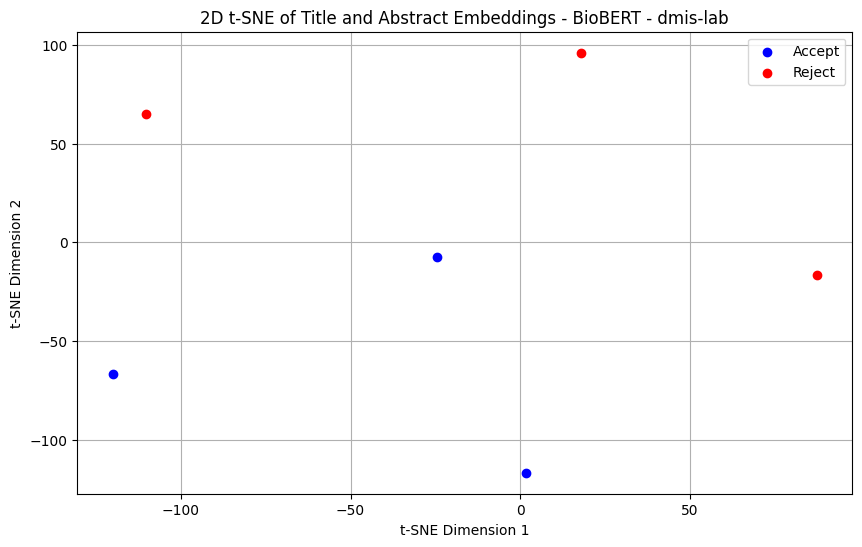

In [59]:
# Visualise

import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

# Concatenate all embeddings
all_embeddings = np.concatenate((accept_embeddings,reject_embeddings),axis=0)

all_embeddings = np.squeeze(all_embeddings,axis=1)

print(all_embeddings.shape)

# Reduce the dimensionality
# Set the perplexity to a value less than the number of samples
perplexity_value = min(30, len(all_embeddings)-1)

#Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2,random_state=42,perplexity=perplexity_value)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Visualise the embeddings
num_accepted = len(accept_embeddings)
# Plotting
plt.figure(figsize=(10,6))
plt.scatter(embeddings_2d[:num_accepted,0],embeddings_2d[:num_accepted,1],color='b',label='Accept')
plt.scatter(embeddings_2d[num_accepted:,0],embeddings_2d[num_accepted:,1],color='r',label='Reject')

plt.title("2D t-SNE of Title and Abstract Embeddings - BioBERT - dmis-lab")

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

`dmis-lab/biobert-base-cased-v1.1` Title and abstracts have distinct accept and reject clusters unlike title only.